# Notebook for the analysis of XPS data 

In [ ]:
2

: 

In [2]:
import numpy as np
import pandas as pd

/Users/a129544/anaconda3/envs/XPS/lib/python3.8/site-packages/arpes/config.py:54: UserWarning: Could not find local configuration file. If you don't have one, you can safely ignore this message.
  warnings.warn(msg)


Activating auto-logging. Current session state plus future input saved.
Filename       : logs/unnamed_2023-06-10_11-34-19.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


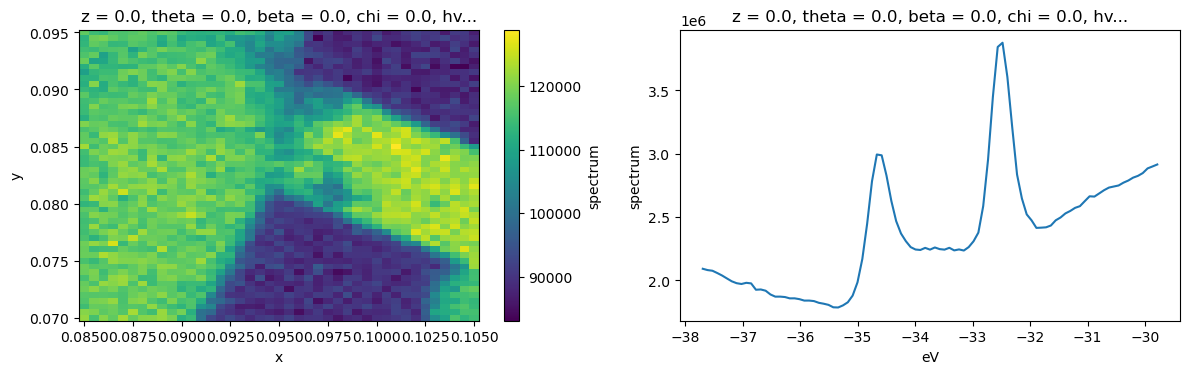

In [2]:
from arpes.io import example_data
import matplotlib.pyplot as plt

xps = example_data.nano_xps

fig, axes = plt.subplots(1, 2, figsize=(12,4))
xps.sum("eV").S.plot(ax=axes[0])
xps.sum(["x", "y"]).S.plot(ax=axes[1])
plt.tight_layout()

# Decomposition analysis 

In order to identify the different process we may use a combination of PCCA and manual exploration

In [3]:
from arpes.analysis.decomposition import pca_along
import xarray as xr

n_components = 5
data, pca = pca_along(xps, ["x", "y"], n_components=n_components)

/Users/a129544/anaconda3/envs/XPS/lib/python3.8/site-packages/arpes/provenance.py:220: UserWarning: Parent array has no ID.
  warnings.warn("Parent array has no ID.")


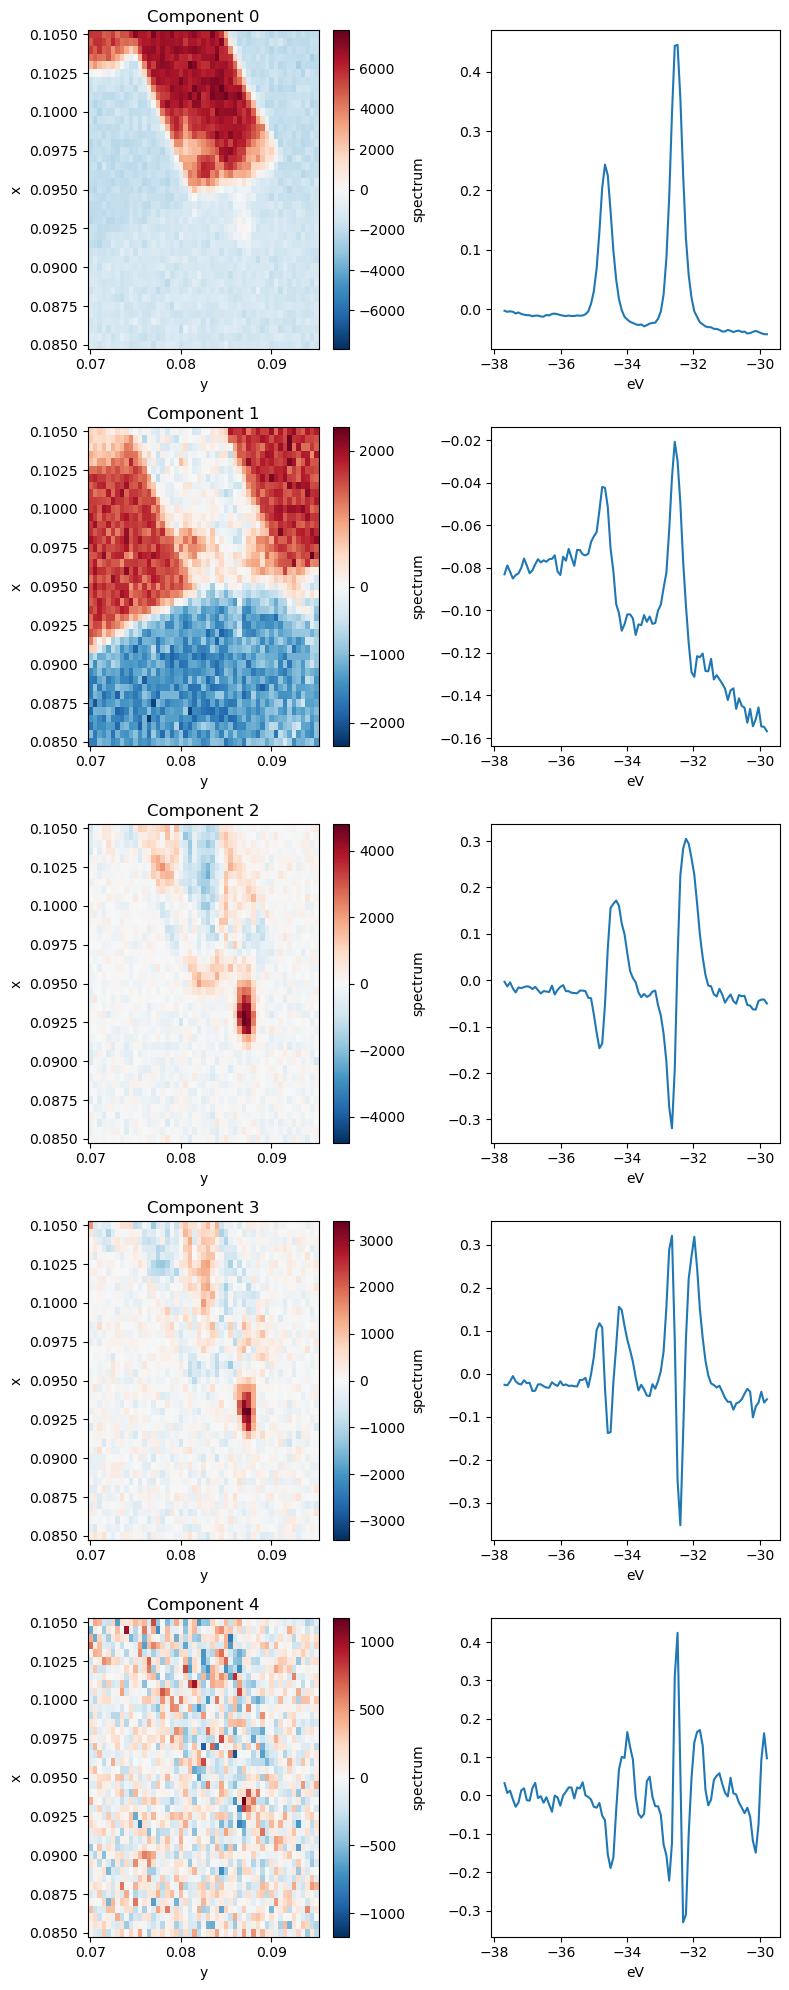

In [4]:
fig, ax = plt.subplots(n_components, 2, figsize=(8, 4 * n_components))

for component in range(n_components):
    data.isel(components=component).S.plot(ax=ax[component, 0])
    ax[component, 0].set_title(f"Component {component}")

    xr.DataArray(pca.components_[component], {"eV": xps.eV.values}, ["eV"]).plot(ax=ax[component, 1])

plt.tight_layout()

# Select data using PCA decomposition

Assume we wanto for semplicity just pick the first component of PCCA 

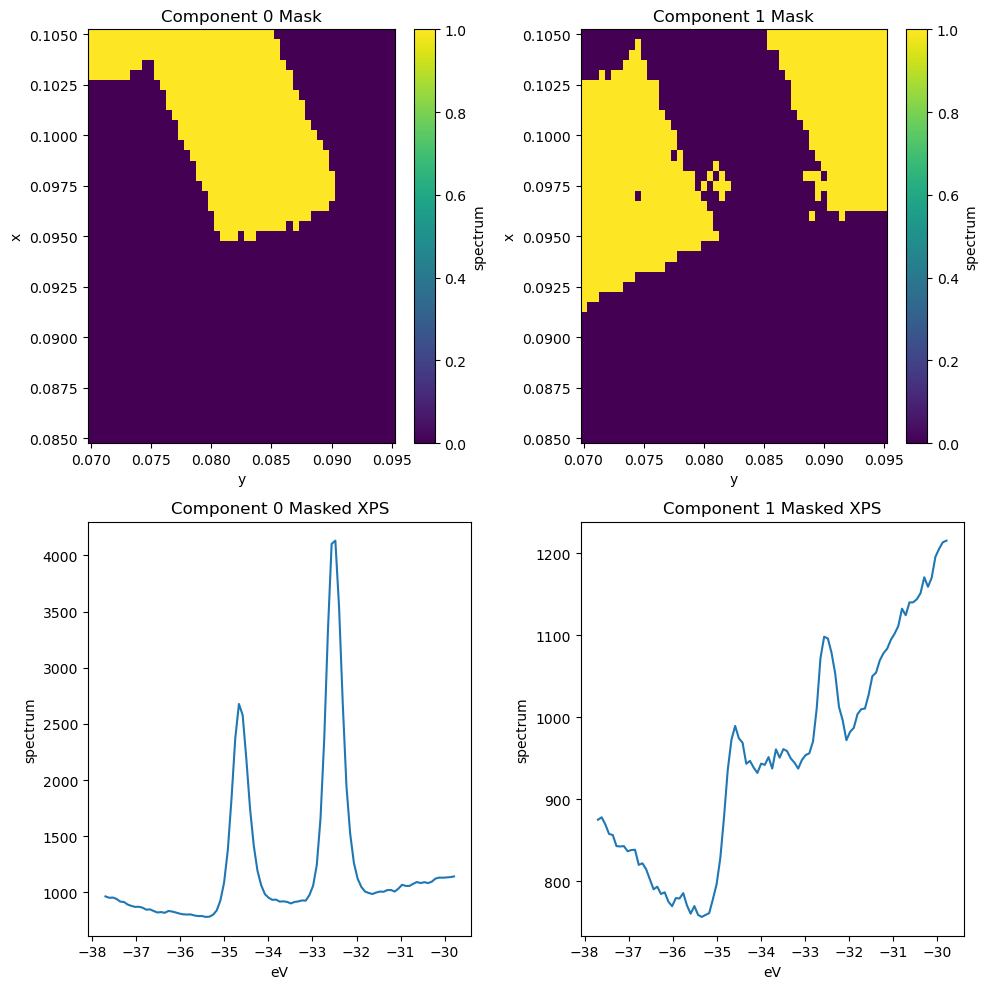

In [5]:
ws2_mask = (data.isel(components=0) > 500)
substrate_mask = (data.isel(components=1) > 1000)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ws2_mask.S.plot(ax=ax[0,0])
substrate_mask.S.plot(ax=ax[0,1])

xps.spectrum.where(ws2_mask).mean(["x", "y"]).S.plot(ax=ax[1,0])
xps.spectrum.where(substrate_mask).mean(["x", "y"]).S.plot(ax=ax[1,1])

ax[0,0].set_title("Component 0 Mask")
ax[0,1].set_title("Component 1 Mask")
ax[1,0].set_title("Component 0 Masked XPS")
ax[1,1].set_title("Component 1 Masked XPS")

plt.tight_layout()



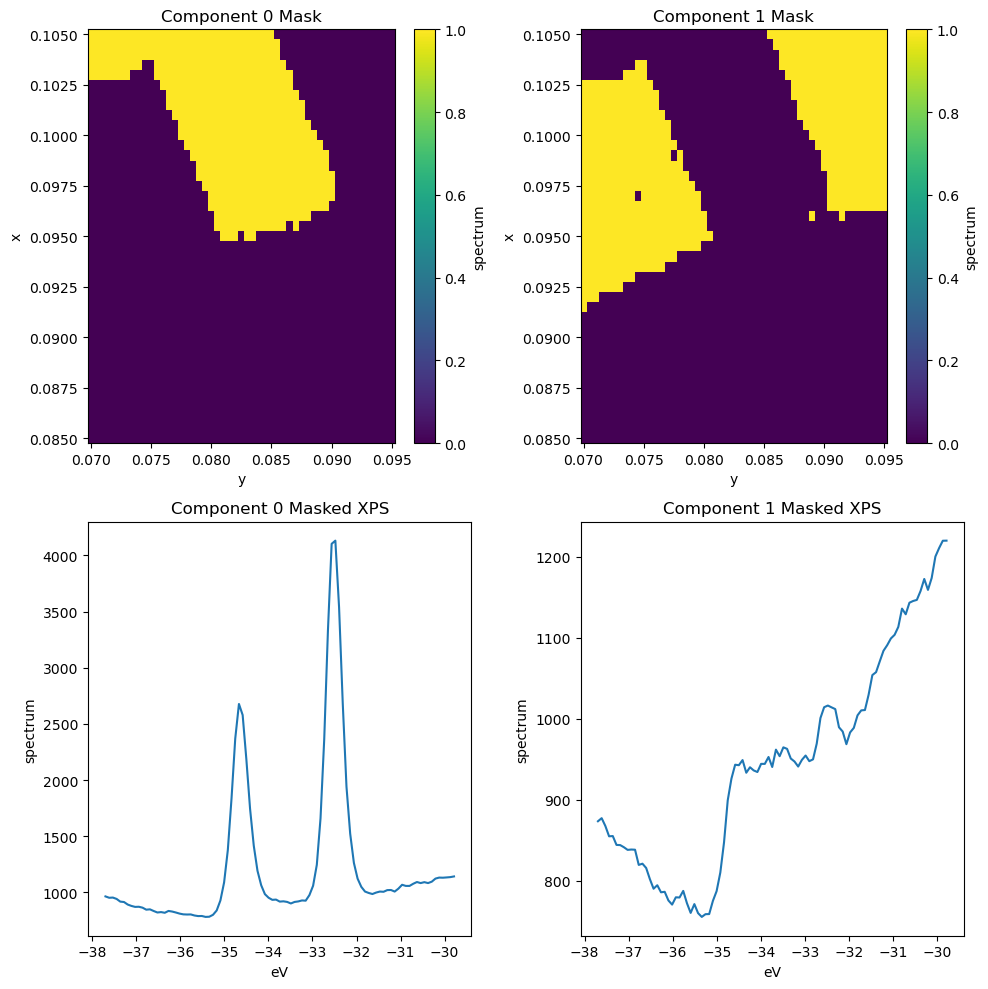

In [6]:
ws2_mask = (data.isel(components=0) > 500)
substrate_mask = (data.isel(components=1) > 1000) & ~ws2_mask

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ws2_mask.S.plot(ax=ax[0,0])
substrate_mask.S.plot(ax=ax[0,1])

xps.spectrum.where(ws2_mask).mean(["x", "y"]).S.plot(ax=ax[1,0])
xps.spectrum.where(substrate_mask).mean(["x", "y"]).S.plot(ax=ax[1,1])

ax[0,0].set_title("Component 0 Mask")
ax[0,1].set_title("Component 1 Mask")
ax[1,0].set_title("Component 0 Masked XPS")
ax[1,1].set_title("Component 1 Masked XPS")

plt.tight_layout()

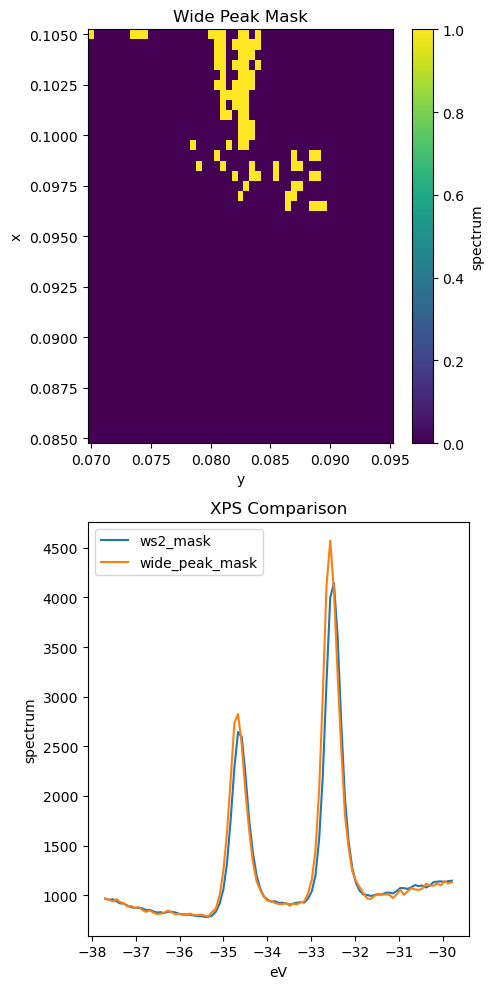

In [7]:
from arpes.config import use_tex
use_tex(False)

ws2_mask = (data.isel(components=0) > 500)
wide_peak_mask = (data.isel(components=3) > 500) & ws2_mask

fig, ax = plt.subplots(2, 1, figsize=(5, 10))
wide_peak_mask.S.plot(ax=ax[0])

xps.spectrum.where(ws2_mask & ~wide_peak_mask).mean(["x", "y"]).S.plot(ax=ax[1], label="ws2_mask")
xps.spectrum.where(wide_peak_mask).mean(["x", "y"]).S.plot(ax=ax[1], label="wide_peak_mask")

ax[1].legend()

ax[0].set_title("Wide Peak Mask")
ax[1].set_title("XPS Comparison")

plt.tight_layout()

# Curve fitting 

First let's try just to fit the model without subtract the background 

name,value,min,max,stderr,vary,expr,brute_step
a_amplitude,1604.528,-inf,inf,43.498,True,,
a_center,-32.495,-inf,inf,0.006,True,,
a_fwhm,0.460,-inf,inf,0.014,False,2.3548200*a_sigma,
a_height,3274.954,-inf,inf,88.782,False,"0.3989423*a_amplitude/max(1e-15, a_sigma)",
a_sigma,0.195,0.000,inf,0.006,True,,
b_amplitude,921.685,-inf,inf,44.285,True,,
b_center,-34.619,-inf,inf,0.011,True,,
b_fwhm,0.477,-inf,inf,0.026,False,2.3548200*b_sigma,
b_height,1814.907,-inf,inf,87.203,False,"0.3989423*b_amplitude/max(1e-15, b_sigma)",
b_sigma,0.203,0.000,inf,0.011,True,,


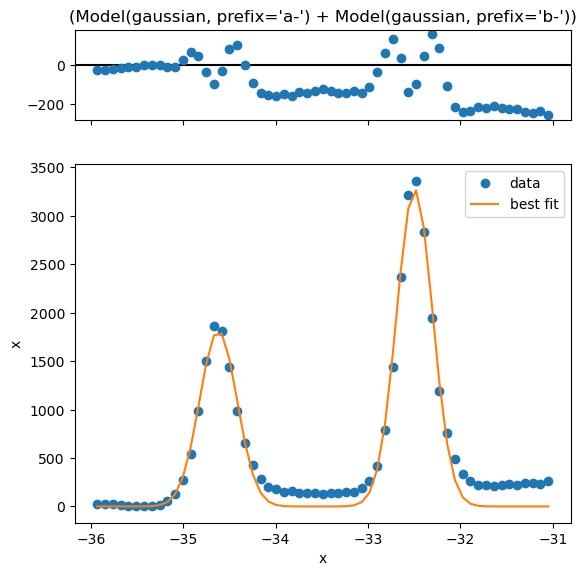

In [12]:
from arpes.fits.fit_models import GaussianModel, AffineBackgroundModel

test_curve = xps.spectrum.where(ws2_mask & ~wide_peak_mask).mean(["x", "y"]).sel(eV=slice(-36, -31))

test_model = GaussianModel(prefix="a_") + GaussianModel(prefix="b_")

result = test_model.guess_fit(
    test_curve - test_curve.min(),
    params={
        "a_center": {"value": -34.6},
        "b_center": {"value": -32.5},
    }
)
result.plot()
result

In [10]:
type( GaussianModel(prefix="a_"))

arpes.fits.fit_models.wrapped.GaussianModel

name,value,min,max,stderr,vary,expr,brute_step
a_amplitude,849.102,-inf,inf,17.487,True,,
a_center,-34.632,-inf,inf,0.005,True,,
a_fwhm,0.467,-inf,inf,0.011,False,2.3548200*a_sigma,
a_height,1708.729,-inf,inf,35.192,False,"0.3989423*a_amplitude/max(1e-15, a_sigma)",
a_sigma,0.198,0.000,inf,0.005,True,,
b_amplitude,1409.191,-inf,inf,16.911,True,,
b_center,-32.509,-inf,inf,0.003,True,,
b_fwhm,0.437,-inf,inf,0.006,False,2.3548200*b_sigma,
b_height,3032.570,-inf,inf,36.392,False,"0.3989423*b_amplitude/max(1e-15, b_sigma)",
b_sigma,0.185,0.000,inf,0.003,True,,


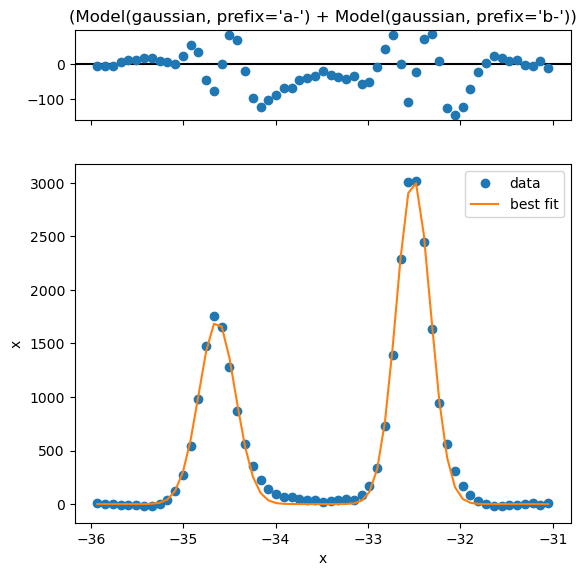

In [11]:
from arpes.fits.fit_models import GaussianModel
from arpes.analysis.shirley import remove_shirley_background
from arpes.fits.utilities import result_to_hints

mask = ws2_mask | (data.isel(components=3) > 800)
test_curve = xps.spectrum.where(mask).mean(["x", "y"]).sel(eV=slice(-36, -31))
test_curve = remove_shirley_background(test_curve)

test_model = GaussianModel(prefix="a_") + GaussianModel(prefix="b_")

result = test_model.guess_fit(
    test_curve,
    params={
        "a_center": {"value": -34.6},
        "b_center": {"value": -32.5},
    }
)
result.plot()
result